## Potential

In [5]:
using Random
using FFTW
using Plots

In [12]:
N = 256
L = 1.0
white_noise = Random.randn(N, N)

256×256 Array{Float64,2}:
 -0.683084     0.692561    1.15345    …   0.147267    0.115657    1.15801
  0.787357     0.127739   -0.557691       1.06936    -0.524585   -0.178486
 -0.69378      0.994842   -0.453111      -0.810688    0.0787575   0.784634
  0.00578586  -0.595394   -0.668537       0.250966   -1.20968     1.77527
  0.759801    -0.14948    -0.832854       0.16576    -0.787316    1.12214
  1.00648      0.308288   -0.0983433  …   0.95123     0.433856    0.926406
 -0.160476     0.611119   -0.80721        0.393679    0.495035   -0.0129281
 -0.216567    -0.465676    0.467887      -0.146569    0.0555894   0.591193
  2.14903      0.372998    0.827895      -2.08421     2.09703    -2.52823
  0.161546    -1.28879     1.21203        0.277767   -0.64647     0.778254
 -0.989162     0.564644    0.425941   …  -1.21198    -0.712439    0.570746
  0.821823    -0.594855    0.103934       0.63059    -0.557463    0.26699
 -0.658683    -2.04467    -0.726224       0.992961   -0.398577    0.0857673
  

In [102]:
function wave_number(N, i)
    if i > N/2
        i - N - 1
    else
        i - 1
    end
end

k = [2 * pi * wave_number(N, n) / L for n in 1:N]

function freq(N, L)
    [2 * pi * wave_number(N, n) / L for n in 1:N]
end

K_sqr = k.^2 .+ k'.^2 ;

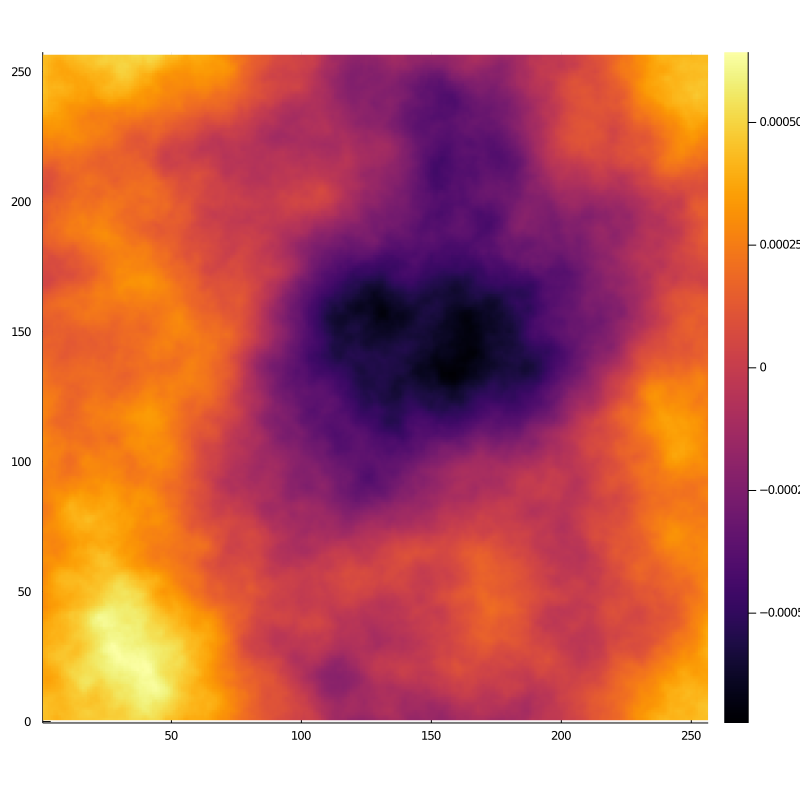

In [65]:
white_noise_f = FFTW.fft(white_noise)
pot_f = white_noise_f ./ K_sqr
pot_f[1, 1] = 0
pot = real(FFTW.ifft(pot_f))
heatmap(pot, aspect_ratio=1, size=(800,800))

In [37]:
function modulo_idx(x, shape)
    CartesianIndex(mod.(Tuple(x) .- 1, shape) .+ 1)
end

modulo_idx (generic function with 1 method)

In [59]:
function dist_func(pot :: Array{Float64,2}, a :: CartesianIndex{2}, b :: CartesianIndex{2})
    loc_a = convert(Array{Float64}, [Tuple(a)...]) .* (L/N)
    loc_b = convert(Array{Float64}, [Tuple(b)...]) .* (L/N)
    geom_dist = mod.(loc_a - loc_b .+ (L/2), L) .- (L/2)
    sum(geom_dist.^2) + pot[a]
end

dist_func (generic function with 2 methods)

In [60]:
neighbours4 = CartesianIndex.(eachcol([-1 0; 0 -1; 1 0; 0 1; 0 0])...)

5-element Array{CartesianIndex{2},1}:
 CartesianIndex(-1, 0)
 CartesianIndex(0, -1)
 CartesianIndex(1, 0)
 CartesianIndex(0, 1)
 CartesianIndex(0, 0)

In [66]:
function check_pixel(dist, cell :: Array{CartesianIndex{2},2}, next :: Array{CartesianIndex{2},2}, home :: CartesianIndex{2})
    pt_ids = [cell[modulo_idx(home + n, N)] for n in neighbours4]
    min = argmin([dist(x, home) for x in pt_ids])
    next[home] = pt_ids[min]
end

check_pixel (generic function with 2 methods)

In [70]:
GridMap = Array{CartesianIndex{2},2}

function step(pot :: Array{Float64,2}, cell :: GridMap, next :: GridMap)
    for home in CartesianIndices(cell)
        check_pixel((a, b)->dist_func(pot, a, b),
                    cell, next, home)
    end
end

step (generic function with 3 methods)

In [219]:
cell = Array(CartesianIndices(pot)) ;

In [234]:
next = Array{CartesianIndex{2},2}(undef, N, N)
while next != cell
    step(pot*50, cell, next)
    cell, next = next, cell
end

In [235]:
function dist_map(pot, cell)
    ((x,y) -> dist_func(pot, x, y)).(cell, CartesianIndices(pot))
end

dist_map (generic function with 1 method)

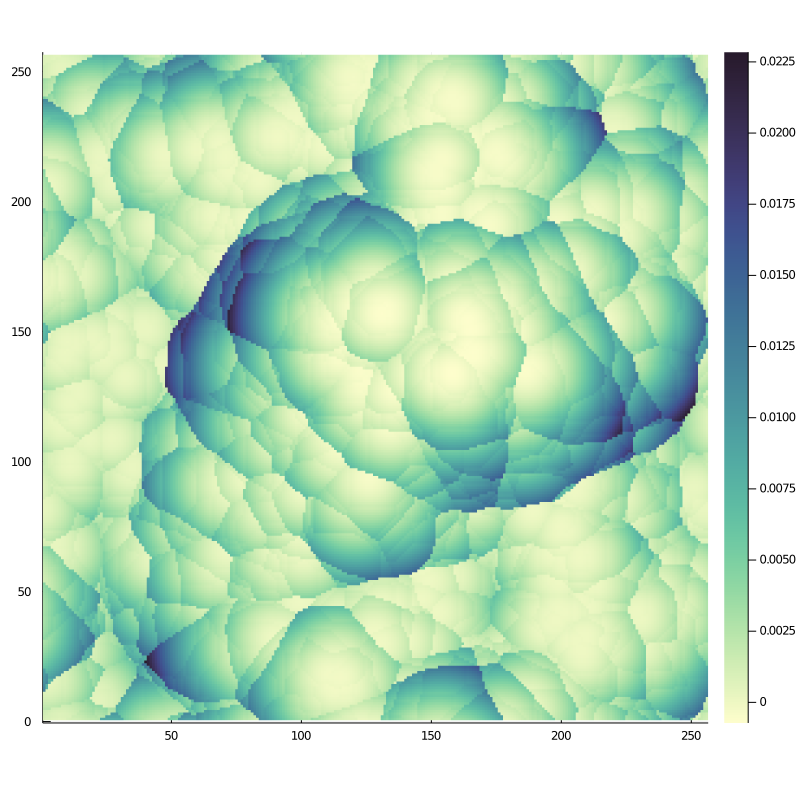

In [236]:
d = dist_map(pot, cell)

heatmap(d, aspect_ratio=1, size=(800,800), color=:deep)

In [237]:
size(d)

(256, 256)

In [238]:
function abs_deriv(x :: Array{Float64, 2})
    N = size(x)[1]
    println(N)
    x_f = FFTW.fft(x)
    # k = freq(N, 1.0)
    # K_sqr = k.^2 + k'.^2
    dx = real(FFTW.ifft(x_f .* k .* 1im))
    dy = real(FFTW.ifft(x_f .* k' .* 1im))
    (dx, dy, sqrt.(dx.^2 + dy.^2))
end

abs_deriv (generic function with 1 method)

In [239]:
function laplace(x :: Array{Float64, 2})
    N = size(x)[1]
    println(N)
    x_f = FFTW.fft(x)
    k = freq(N, N)
    # K_sqr = k.^2 + k'.^2
    sink = sin.(k)
    K_2 = sink.^2 .+ sink'.^2
    y_f = x_f .* K_2
    real(FFTW.ifft(y_f))
end

laplace (generic function with 1 method)

In [240]:
?heatmap

search: heatmap heatmap! plots_heatmap plots_heatmap!



```
heatmap(x,y,z)
heatmap!(x,y,z)
```

Plot a heatmap of the rectangular array `z`.

# Example

```julia-repl
julia> heatmap(randn(10,10))
```


In [241]:
function ∇²(f)
   ∇²f = zero(f) # initialize to zero since we don't touch the boundaries
   for y = 2:size(f,2)-1, x = 2:size(f,1)-1 # compute ∇²f in interior of f
       ∇²f[x,y] = f[x-1,y] + f[x+1,y] + f[x,y-1] + f[x,y+1] - 4f[x,y]
   end
   return ∇²f
end

∇² (generic function with 1 method)

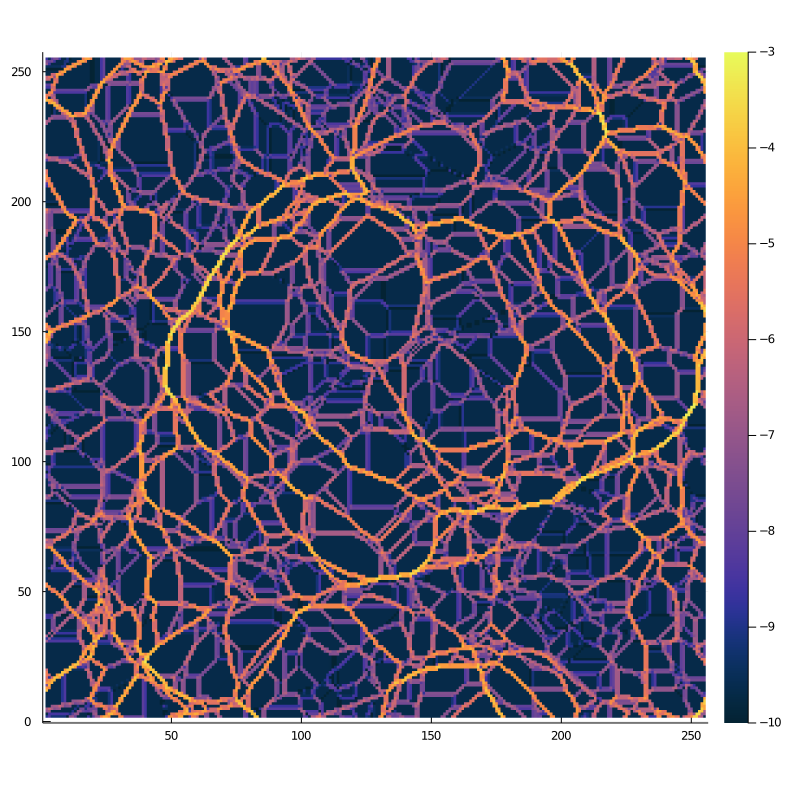

In [249]:
dens = abs.(∇²(d))
# dens = abs.(laplace(d))
heatmap(log.(dens), aspect_ratio=1, size=(800,800), clim=(-10, -3), color=:thermal)